# FloyHub introduction to Deep Learning: Logistic Regression

### Abstract
We are moving to another classical of ML: the handwritten digit recognition with Logistic Regression. This is the first of 3 step which will take us on on state-of-the-art model for this task and in the deeper region of Deep Learning.

## Introduction
We have learnt how to use PyTorch (PT) to perform linear regression to predict an outcome of scalar value, e.g., house prices, given a set of features, e.g., house size.

However, there are times when we want to classify things rather than predict a value, e.g., given an image of a digit we can to classify it as either 0, 1, 2, …, 9, or given a song we want to classify it as pop, rock, rap, etc. Each of the classification in the set [0, 1, 2, …, 9], or [pop, rock, rap, etc.], is known as a class, which in the computer world we represent using a number, e.g., pop = 0, rock = 1, etc. To perform classification, we can employ logistic regression using PT.
In this article, we will use logistic regression to classify the image of a digit, as belonging to classes 0, 1, 2, …, or, 9.

### Table of Contents

- ...

## Logistic Regression vs Linear Regression

The good news is a lot of concepts in linear regression still applies in logistic regression. We can reuse the formula `y = W.x + b`, but with some tweaks. Let’s look at this formula side-by-side for linear and logistic regression:

![LinR vs LogR](https://cdn-images-1.medium.com/max/1280/1*Oy6O6OdzTXbp_Czi_k4mRg.png)

*Differences*:

- **Outcome (y)**: For linear regression, this is a scalar value, e.g., $50K, $23.98K, etc. For logistic regression, this is an integer that refers to a class of e.g., 0, 1, 2, .. 9. To be more clear is called regression because the output of each class is in range [0,1], but we have a classification task so in the end we have an output which represent one of this class.

- **Features (x)**: For linear regression, each feature is represented as an element in a column vector. For logistic regression involving a 2-D image, this is a 2-dimensional vector, with each element representing a pixel of the image; each pixel has a value of 0–255 representing a grayscale where 0 = black, and 255 = white, and other values some shade of grey.

- **Cost function (cost)**: For linear regression, this is some function calculating the aggregated difference between each prediction and its expected outcome. For logistic regression, this is some function calculating the aggregation of whether each prediction is right or wrong.

*Similarity*:

- **Training**: The training goals of both linear and logistic regression are to learn the weights (W) and biases (b) values.
- **Outcome**: The intention of both linear and logistic regression is to predict/classify the outcome (y) with the learned W, and b.

## Collect a Dataset

For this task we will use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset that we have already uploaded for you as FloydHub dataset. If you have followed the steps in the `README.md` or in the article, you will be able to load the MNIST dataset from the `input` path.

First of all we import all the package we need for running this tutorial.

In [23]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# CUDA?
cuda = torch.cuda.is_available()

The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision. `torchvision.datasets` provide a great API to handle the MNIST dataset. The snippet of code below, will create the MNIST dataset, then we will dive into to take a look about MNIST samples.

Training Data Size:  torch.Size([60000, 28, 28]) - torch.Size([60000])
Testing Data Size:  torch.Size([10000, 28, 28]) - torch.Size([10000])


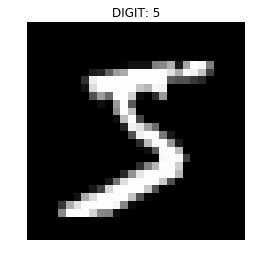

In [3]:
# MNIST Dataset (Images and Labels)
# If you have not mounted the dataset, you can download it
# just adding download=True as parameter
train_dataset = dsets.MNIST(root='/input', 
                            train=True, 
                            transform=transforms.ToTensor())
x_train_mnist, y_train_mnist = train_dataset.train_data.type(torch.FloatTensor), train_dataset.train_labels
test_dataset = dsets.MNIST(root='/input', 
                           train=False, 
                           transform=transforms.ToTensor())
x_test_mnist, y_test_mnist = test_dataset.test_data.type(torch.FloatTensor), test_dataset.test_labels

print('Training Data Size: ' ,x_train_mnist.size(), '-', y_train_mnist.size())
print('Testing Data Size: ' ,x_test_mnist.size(), '-', y_test_mnist.size())

plt.imshow(x_train_mnist[0].numpy(), cmap='gray')
plt.title('DIGIT: %i' % y_train_mnist[0])
plt.axis('off')
plt.show()

`torch.utils.data.DataLoader` combines a dataset and a sampler, and provides single or multi-process iterators over the dataset.

In [4]:
# Hyperparameter
batch_size = 8

# Training Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

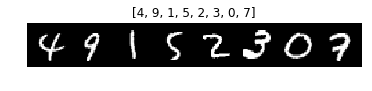

In [5]:
# Plot a grid of images
def imshow(inp_tensor, title):
    """image show for Tensor"""
    img = inp_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch
trainset_iter = iter(train_loader)
images, labels = trainset_iter.next()
# show images
batch_imgs = make_grid(images, nrow=batch_size)
plt.axis('off')
imshow(batch_imgs, title=[x for x in labels])

## Reconcile Logistic and Linear Regression

To make logistic regression work with y = W.b + x, we need to make some changes to reconcile the differences stated above.

### Feature transformation, x

We can convert the 2-dimensional image features in our logistic regression example (assuming it has X rows, Y columns) into a 1-dimensional one (as required in linear regression) by appending each row of pixels one after another to the end of the first row of pixels as shown below.

![Feature transformation](https://cdn-images-1.medium.com/max/1280/1*Vo8PMHppg_lWxFAZHZzNGQ.png)

### Predicted Outcome Transformation, y

For logistic regression, we cannot leave y (predicted outcome) as a scalar since the prediction may end up being 2.3, or 11, which is NOT in the possible classes of [0, 1, …, 9].

To overcome this, the prediction y should be transformed into a single column vector (shown below as row vector to conserve space) where each element represents the score of what the logistic regression model thinks is likely a particular class. In the example below, class ‘1’ is the prediction since it has the highest score.

![Predicted Outcome Transformation](https://cdn-images-1.medium.com/max/1280/1*Ld1fM5euVXm16mTf-4ifZA.png)

To derive this vector of scores, for a given image, each pixel on it will contribute a set of scores (one for each class) indicating the likelihood it thinks the image is in a particular class, based **ONLY** on its own greyscale value. The sum of all the scores from every pixel for each class becomes the prediction vector.

![Predicted Outcome Transformation 2](https://cdn-images-1.medium.com/max/1280/1*aOP0s2i587kDJW2Td7GNqQ.png)

### Cost Function Transformation

We cannot use as cost function, any function that involves numerical distance between predicted and actual outcomes. Such a cost function, for an image of ‘1’, will penalize a prediction of ‘7’, more heavily (7–1=6) than a prediction of ‘2’ (2–1=1), although both are equally wrong.

The cost function we are going to use, cross entropy (H) involves multiple steps:

1. Convert actual image class vector (y’) into a one-hot vector, which is a probability distribution
2. Convert prediction class vector (y) into a probability distribution
3. Use cross entropy function to calculate cost, which is the difference between 2 probability distribution function

#### *Step 1. One-hot Vectors*

Since we already transformed prediction (y) in to a vector of scores, we should also transform the actual image class (y’) into a vector as well; each element in the column vector represents a class with every element being ‘0’ except the element corresponding to the actual class being ‘1’. This is known as a one-hot vector. Below we show the one-hot vector for each class from 0 to 9.

![one-hot-vector](https://cdn-images-1.medium.com/max/1280/1*YFh3GZ41PgQWAnB_LfmJVw.png)

Assuming the actual (y’) image being 1, thus having a one-hot vector of [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], and the prediction vector (y) of [1.3, 33, 2, 1.2, 3.2, 0.5, 3, 9.2, 1], plotting them for comparison becomes:

![one-hot vs prob](https://cdn-images-1.medium.com/max/1280/1*HtZU15da9Tip9kF83YY7Ag.png)

#### *Step 2. Probability Distribution with softmax*

To mathematically compare similarity of two ‘graphs’, cross-entropy is a great way (and here is a fantastic albeit long explanation for those with a stomach for details).

To utilize cross entropy however, we need to convert both the actual outcome vector (y’) and the prediction outcome vector (y) values into a ‘probability distribution’, and by ‘probability distribution’ we mean:

- The probability/score of each class has to be between 0 to 1
- The sum of all the probabilities/score for all classes has to be 1

The actual outcome vector (y’) being one-hot vectors already satisfy these constraints.

For prediction outcome vector (y), we can transform it into a probability distribution using softmax:

![softmax](https://cdn-images-1.medium.com/max/1280/1*gmOykUVXXUYK7LPDVZHMBg.png)

This is simply a 2-step process (see S1, S2 below), where each element in the prediction score vector (y), is exp’ed, and divided by the sum of the exp’ed total.

![how softmax works](https://cdn-images-1.medium.com/max/1280/1*yHfAuzJud7Za0BGOT-mwAg.png)

Note that softmax(y) graph is similar in shape to the prediction (y) graph but merely with larger max and smaller min values.

![softmax vs pred](https://cdn-images-1.medium.com/max/1280/1*0BW3r-W89s9-8HUz_EhauA.png)

#### *Step 3. Cross Entropy*

We can now apply cross-entropy (H) between the predicted vector score probability distribution (y’) and the actual vector score probability distribution (y).

The cross entropy formula is:

![CE](https://cdn-images-1.medium.com/max/1280/1*eNII64IH9v4JLJo-jfOBug.png)

To quickly understand this complex formula, we break it down into 3 parts (see below). Note that as notation in this article, we use y_i to represent “y with i subscript” in the formula H:

![splitting CE](https://cdn-images-1.medium.com/max/1280/1*MlJX2kL8vRPQU5xcgvS8bQ.png)

- Blue: Actual outcome vector, y_i’
- Red: -log of the probability distribution of prediction class vector, (softmax(y_i)), explained previously
- Green: Sum of multiplication of blue and red components for each image class i, where i = 0, 1, 2, …, 9

The illustrations below should simplify understanding further.

The blue plot is just the one-hot vector of actual image class (y’), see **One-hot Vector** section:

![one hot vect](https://cdn-images-1.medium.com/max/1280/1*-vPuYJvh8l7uSBKTl9Vm4w.png)

The red plot is derived from transformations of each prediction vector element, y, to softmax(y), to -log(softmax(y):

![from pred to ce](https://cdn-images-1.medium.com/max/1280/1*AI9hbnU5SM8gLhGVhLASnQ.png)

(IF author allows)
If you wish to fully understand why -log(softmax(y)) inverses softmax(y), the second transformation, please check out the video or slides.

The cross entropy (H), the green part (see below) is the multiplication of blue and red values for each class, and then summing them up as illustrated:

![CE explained](https://cdn-images-1.medium.com/max/1280/1*1wMxL3RsjfdSHhcbPd3R3g.png)

Since the blue plot is a one-hot vector, it has only a single element of 1, which is for the correct image class, all other multiplications in the cross entropy (H) is 0, and H simplifies to:
```
Cross Entropy (H) = -log(softmax(y_i))
Where:
- y_i: Predicted score/probability for correct image class
```

In [19]:
# Hyperparameter
batch_size = 64

# Training Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## Choose a Model

We have defined in great details how transfrom our previous Linear Model to a Logistic Model. In the next snippet of code we will translate everything in PyTorch code. 

In [20]:
# Hyperparameters
input_size = 784 # 28 * 28
num_classes = 10
learning_rate = 1e-3

#### Model ####
# Logistic Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

model = LogisticRegression(input_size, num_classes)

# If you are running a GPU instance, load the model on GPU
if cuda:
    model.cuda()
    

#### Loss and Optimizer ####
# Softmax is internally computed.
loss_fn = nn.CrossEntropyLoss()
# If you are running a GPU instance, compute the loss on GPU
if cuda:
    loss_fn.cuda()
    
# Set parameters to be updated.  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Train

We will train our model for 5 epochs and evaluate on test set.

In [21]:
# Hyperparameters
num_epochs = 5
print_every = 100

# Metrics
train_loss = []
train_accu = []

# Model train mode
model.train()
# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # image unrolling
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Load loss on CPU
        if cuda:
            loss.cpu()
        loss.backward()
        optimizer.step()
        
        ### Keep track of metric every batch
        # Loss Metric
        train_loss.append(loss.data[0])
        # Accuracy Metric
        prediction = outputs.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(labels.data).sum()/batch_size*100
        train_accu.append(accuracy)
        
        # Log
        if (i+1) % print_every == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f, Accuracy: %.4f' 
                   % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0], accuracy))

Epoch: [1/5], Step: [100/937], Loss: 2.2347, Accuracy: 18.7500
Epoch: [1/5], Step: [200/937], Loss: 2.1090, Accuracy: 37.5000
Epoch: [1/5], Step: [300/937], Loss: 2.0425, Accuracy: 42.1875
Epoch: [1/5], Step: [400/937], Loss: 1.9319, Accuracy: 62.5000
Epoch: [1/5], Step: [500/937], Loss: 1.8402, Accuracy: 76.5625
Epoch: [1/5], Step: [600/937], Loss: 1.7994, Accuracy: 65.6250
Epoch: [1/5], Step: [700/937], Loss: 1.6974, Accuracy: 84.3750
Epoch: [1/5], Step: [800/937], Loss: 1.6696, Accuracy: 73.4375
Epoch: [1/5], Step: [900/937], Loss: 1.5868, Accuracy: 75.0000
Epoch: [2/5], Step: [100/937], Loss: 1.5487, Accuracy: 76.5625
Epoch: [2/5], Step: [200/937], Loss: 1.5950, Accuracy: 60.9375
Epoch: [2/5], Step: [300/937], Loss: 1.4780, Accuracy: 70.3125
Epoch: [2/5], Step: [400/937], Loss: 1.4457, Accuracy: 78.1250
Epoch: [2/5], Step: [500/937], Loss: 1.3660, Accuracy: 81.2500
Epoch: [2/5], Step: [600/937], Loss: 1.3485, Accuracy: 82.8125
Epoch: [2/5], Step: [700/937], Loss: 1.2997, Accuracy: 

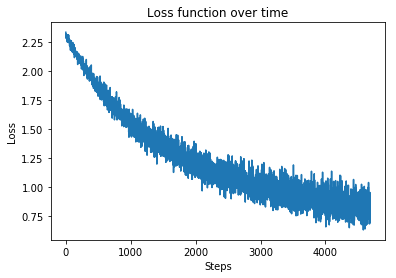

In [27]:
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss function over time")
plt.plot(np.arange(len(train_loss)), train_loss)

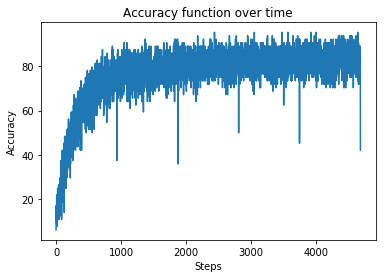

In [28]:
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy function over time")
plt.plot(np.arange(len(train_accu)), train_accu)

## Evaluate

Let's evaluate our model on test set.

In [30]:
model.eval()
correct = 0
for data, target in test_loader:
    data, target = Variable(data.view(-1, 28*28), volatile=True), Variable(target)
    if cuda:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    # Load output on CPU
    if cuda:
        output.cpu()
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 84.51%


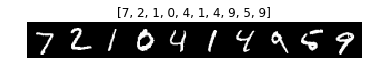

In [49]:
# Test Label

# Hyperparameter
batch_size = 10

# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Plot a grid of images
def imshow(inp_tensor, title):
    """image show for Tensor"""
    img = inp_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch
testset_iter = iter(test_loader)
images, labels = testset_iter.next()
# show images
batch_imgs = make_grid(images, nrow=batch_size)
plt.axis('off')
imshow(batch_imgs, title=[x for x in labels])

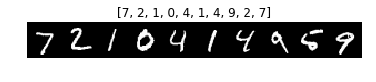

In [50]:
# Result from Training

input = Variable(images.view(-1, 28*28), volatile=True)
output = model(input)
# Load output on CPU
if cuda:
    output.cpu()
    
plt.axis('off')
imshow(batch_imgs, title=[x for x in output.data.max(1)[1]])

## Is it possible to do better?

Of course it is! in the next episode we move into the realm of deep computation introducing Neural Network! It's time to go deeper.

## Summary

We have reached another great milestone and a basic building block in our DL journey.

- In this tutorial we have explored the MNIST dataset
- We have introduced what is Logistic Regression, Softmax and Cross Entropy
- We have trained the model for 5 epochs and plot log and accuracy
- Finally we have evaluate the trained model reaching an accuracy of 84.51%

## It's you turn!

Now it's your turn to test what you have learned on new knowledge: explore the dataset or take a new one, change hyperparamters, hack the logistic model, explore new loss functions, try others optimizers or if you are eager to learn, What are you expecting to move on the intermediate episode? ;)

## Thanks and Resources

Big thanks to:
- ...

Resources:
- [the-gentlest-introduction-to-tensorflow](https://medium.com/all-of-us-are-belong-to-machines/gentlest-intro-to-tensorflow-4-logistic-regression-2afd0cabc54)
- [yunjey-pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial)
- Dataset MNIST 
- [another MNIST example](https://github.com/rickiepark/pytorch-examples/blob/master/mnist.ipynb)
- [PyTorch Dataset Example](https://github.com/ncullen93/torchsample/blob/master/examples/Transforms%20with%20Pytorch%20and%20Torchsample.ipynb)